In [4]:
# Setup imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [147]:
df = pd.read_csv("Country-data.csv")
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset shape: (167, 10)

First few rows:
               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  


In [154]:
features = df.drop(columns=["country", "exports", "imports"]).columns.copy()
features

Index(['child_mort', 'health', 'income', 'inflation', 'life_expec',
       'total_fer', 'gdpp'],
      dtype='object')

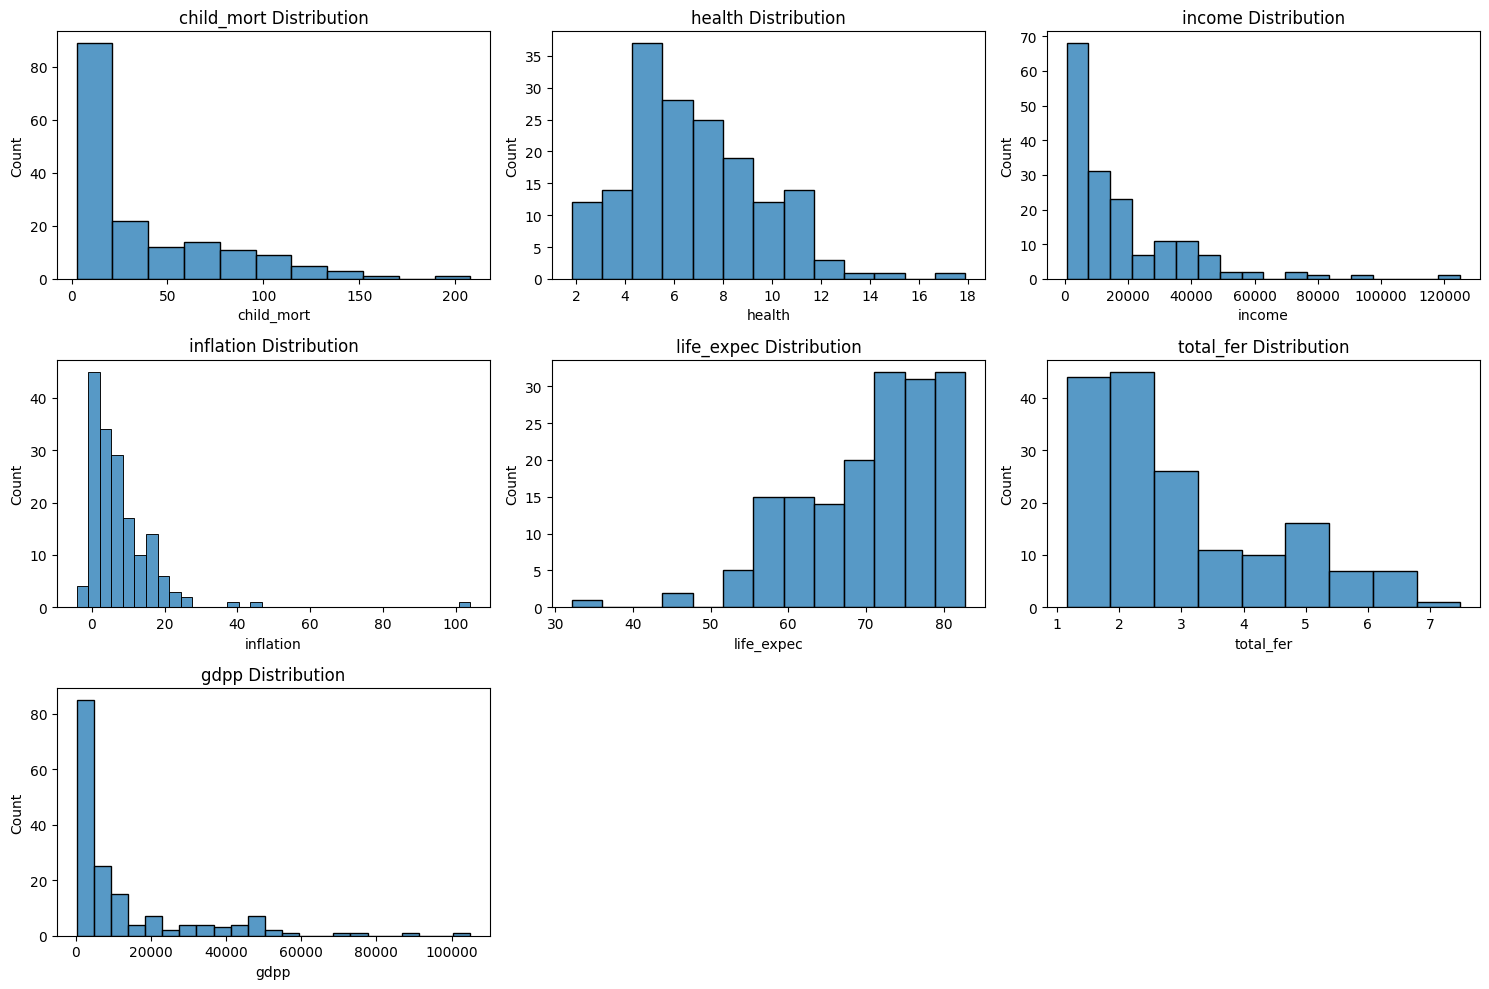

In [160]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=feature)
    plt.title(f"{feature} Distribution")
plt.tight_layout()
plt.show()

In [161]:
scaler = StandardScaler()
X = df[features].values
X_scaled = scaler.fit_transform(X)
print(X_scaled)

[[ 1.29153238  0.27908825 -0.8082454  ... -1.61909203  1.90288227
  -0.67917961]
 [-0.5389489  -0.09701618 -0.3753689  ...  0.64786643 -0.85997281
  -0.48562324]
 [-0.27283273 -0.96607302 -0.22084447 ...  0.67042323 -0.0384044
  -0.46537561]
 ...
 [-0.37231541  0.0088773  -0.65840354 ...  0.28695762 -0.66120626
  -0.63775406]
 [ 0.44841668 -0.59727159 -0.65892382 ... -0.34463279  1.14094382
  -0.63775406]
 [ 1.11495062 -0.33801514 -0.72135793 ... -2.09278484  1.6246091
  -0.62954556]]


In [162]:
class KMeans:
    def __init__(self, k: int = 4, max_iter: int = 400, tol: float = 1e-6):
        self.k = k
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None
        self.clusters = None

    def _distance(self, data: np.ndarray, centroids: np.ndarray) -> np.ndarray:
        distances = np.zeros((data.shape[0], centroids.shape[0]))
        for i, centroid in enumerate(centroids):
            distances[:, i] = np.sum((data - centroid) ** 2, axis=1)
        return distances
    
    def _assign_clusters(self, data: np.ndarray) -> np.ndarray:
        distances = self._distance(data, self.centroids)
        return np.argmin(distances, axis=1)
    
    def _calculate_total_distance(self, data: np.ndarray) -> float:
        total = 0.0
        for i, centroid in enumerate(self.centroids):
            pts = data[self.clusters == i]
            if pts.size == 0:
                continue
            total += np.sum((pts - centroid) ** 2)
        return total
    
    def _update_centroids(self, data: np.ndarray) -> np.ndarray:
        new_centroids = np.zeros((self.k, data.shape[1]))
        for i in range(self.k):
            pts = data[self.clusters == i]
            if pts.size == 0:
                new_centroids[i] = data[np.random.randint(0, data.shape[0])]
            else:
                new_centroids[i] = pts.mean(axis=0)
        return new_centroids

    def fit(self, data: np.ndarray) -> None:
        # First initialise k random points, as our current centroids
        idx = np.random.choice(data.shape[0], self.k, replace=False)
        self.centroids = data[idx].copy()
        self.clusters = self._assign_clusters(data)

        # Keep track of best result yet

        curr_distance = self._calculate_total_distance(data)

        lowest_loss = curr_distance
        best_centroids = self.centroids
        best_clusters = self.clusters

        if curr_distance < self.tol:
            return
        
        for _ in range(self.max_iter):
            self.centroids = self._update_centroids(data)
            self.clusters = self._assign_clusters(data)
            new_distance = self._calculate_total_distance(data)

            if new_distance < lowest_loss:
                lowest_loss = new_distance
                best_centroids = self.centroids
                best_clusters = self.clusters

            if np.abs(curr_distance - new_distance) < self.tol:
                break
            curr_distance = new_distance

        self.centroids = best_centroids
        self.clusters = best_clusters


In [163]:
kmeans = KMeans(k=4, max_iter=10000)
kmeans.fit(X_scaled)
kmeans.clusters

df["cluster"] = kmeans.clusters
df["cluster"].value_counts().sort_index()

cluster
0    86
1    33
2     3
3    45
Name: count, dtype: int64

The convergence criterion is when the change in distance is less than 1e-10, or 10000 iterations. Usually, the algorithm converges in a few steps (15-20).

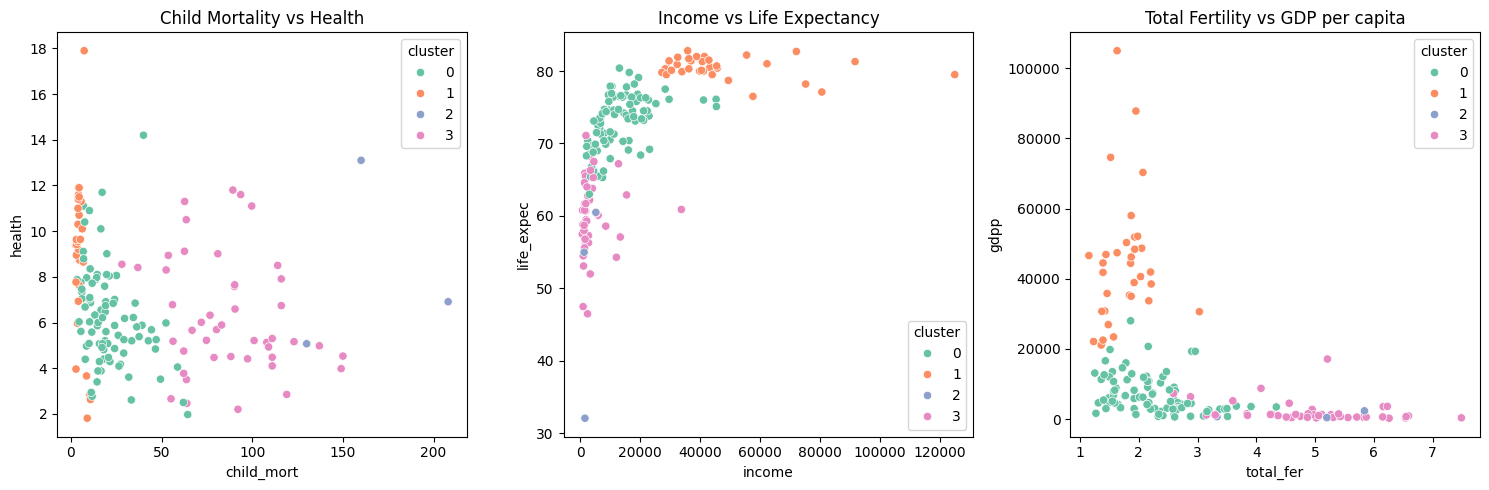

In [164]:
plt.figure(figsize=(15, 5))

# We need to visualise the clusters for child mort vs health
plt.subplot(1, 3, 1)
sns.scatterplot(data=df, x="child_mort", y="health", hue="cluster", palette="Set2")
plt.title("Child Mortality vs Health")

# income vs life expectancy
plt.subplot(1, 3, 2)
sns.scatterplot(data=df, x="income", y="life_expec", hue="cluster", palette="Set2")
plt.title("Income vs Life Expectancy")

# total fertility vs gdpp
plt.subplot(1, 3, 3)
sns.scatterplot(data=df, x="total_fer", y="gdpp", hue="cluster", palette="Set2")
plt.title("Total Fertility vs GDP per capita")

plt.tight_layout()
plt.show()

## Cluster Analysis

In [165]:
for cluster in df["cluster"].sort_values().unique():
    print(f"\n=== Cluster {cluster} ===")
    stats = (
        df[df["cluster"] == cluster]
        .drop(columns=["cluster"])
        .describe(percentiles=[0.5])
        .drop(['count', 'min', 'max'])
        .transpose()  # Transpose for better formatting
    )
    print(stats.round(2))



=== Cluster 0 ===
                mean      std       50%
child_mort     21.31    13.88     17.75
exports        41.20    19.62     37.65
health          6.21     2.16      5.93
imports        47.65    19.87     48.95
income      13098.72  8838.52  10700.00
inflation       7.42     7.85      5.72
life_expec     73.07     3.78     73.85
total_fer       2.26     0.67      2.18
gdpp         6984.56  5451.44   5050.00

=== Cluster 1 ===
                mean       std       50%
child_mort      4.88      2.15      4.20
exports        57.66     43.67     49.40
health          8.95      3.25      9.49
imports        50.37     38.18     37.40
income      46957.58  21229.33  40700.00
inflation       2.72      4.10      1.22
life_expec     80.47      1.44     80.40
total_fer       1.76      0.38      1.84
gdpp        44627.27  18381.77  41900.00

=== Cluster 2 ===
               mean      std      50%
child_mort   166.00    39.34   160.00
exports       19.13     5.39    16.80
health         8.36

In [166]:
# Now here, I will print the characteristics of each cluster
# a feature is characteristic if in the cluster, |it's mean - global mean| is more than the standard deviation globally
for cluster in df["cluster"].sort_values().unique():
    print(f"\n=== Cluster {cluster} ===")
    for feature in df.drop(columns=["country", "cluster"]).columns:
        cluster_data = df[df["cluster"] == cluster][feature]
        global_mean = df[feature].mean()
        if np.abs(cluster_data.mean() - global_mean) > df[feature].std():
            print(f"{feature}: {cluster_data.mean().round(2)} (global: {global_mean.round(2)})")


=== Cluster 0 ===

=== Cluster 1 ===
income: 46957.58 (global: 17144.69)
life_expec: 80.47 (global: 70.56)
gdpp: 44627.27 (global: 12964.16)

=== Cluster 2 ===
child_mort: 166.0 (global: 38.27)
inflation: 42.22 (global: 7.78)
life_expec: 49.2 (global: 70.56)
total_fer: 4.79 (global: 2.95)

=== Cluster 3 ===
child_mort: 86.65 (global: 38.27)
life_expec: 59.91 (global: 70.56)
total_fer: 5.01 (global: 2.95)
